# ResNet and DenseNet - Deep Learning Seminar WS 19/20

|                     |                                                        |
|:--------------------|:-------------------------------------------------------|
| Due date            | 27.01.2020                                             |
| Student             | Alexander Bierenstiel                                  |
| Course of study     | INFM (CS masters degree)                               |
|                     | HS Offenburg (University of Applied Sciences Offenburg)|


# Preface

## Structure
This notebook is divied into two main sections [`Experiment`](#scrollTo=OndgzxVOwNPD) and [`Analysis`](#scrollTo=sk6TbIIGveVj).

In [`Experiment`](#scrollTo=OndgzxVOwNPD) a single experiment is run. If you wish to run more than one experiment, you have to use the configuration of another experiment and rerun the [`Experiment`](#scrollTo=OndgzxVOwNPD) section.

In [`Analysis`](#scrollTo=sk6TbIIGveVj) the analysis of the experiment results is done. In the subsection [`Single model analysis`](#scrollTo=pTotfi6JyJs6) the model and results of the current experiment are analysed. In the subsection [`Multiple model analysis`](#scrollTo=2WP6GuDreLdw) the models and results of multiple experiments are compared to each other.

## Dataset
The data set used in this notebook is the RoboCup dataset of the [Sweaty project group of HS Offenburg](https://sweaty.hs-offenburg.de/en/sweaty/).
Sweaty is a humanoid robot with the task of playing soccer. The Sweaty team continuously participates in the annual RoboCup competition to compete against other teams and their robots.

The dataset used in this notebook originates from a subset of photographies done by Sweaty during competition conditions. We will use the dataset for our experiments. If you are a student or intern of the HS Offenburg you can download the dataset from the [Moodle course](https://elearning.hs-offenburg.de/moodle/course/view.php?id=4372) using this [link](https://elearning.hs-offenburg.de/moodle/mod/resource/view.php?id=173031).

## Experiments and Default Parameters
Multiple experiments have been carried out for this seminar. For every experiment a different set of parameters is used. Unless parameters are not explicitly stated for an given experiment the following default parameters are used as statet in *`table 1`*.

<center>[ <i>Table 1: Default parameters</i> ]</center>

| Parameter           | ResNet-50 pretrained with ImageNet data |
|:--------------------|:----------------------------------------|
| <b>Optimizer        | Adam                                    |
| <b>Loss-Function    | Categorical Crossentropy                |
| <b>Metrics          | Accuracy, Categorical Accuracy          |
| <b>Train Batch Size | 10                                      |
| <b>Test Batch Size  | 10                                      |
| <b>Epochs           | 50                                      |

In total 4 groups of experiments have been carried out with a total of 10 experiments. Because of reusing results of prior experiment in other experiment groups the number of unique experiments to carry out is reduced to 7. The experiment groups and their experiments are listed below in *`table 2`*.

<center>[ <i>Table 2: Experiment groups and their configuration</i> ]</center>

| Experiment Group (Changed Parameter) | Experiment (Changed Parameter Instance)|
|:------------------------------|:---------------------------------------------|
| <b>Default                    | Default parameters                           |
|                               |                                              |
| <b>ResNet Depth               | (Default) ResNet-50                          |
|                               | ResNet-101                                   |
|                               | ResNet-152                                   |
|                               |                                              |
| <b>Model / Architecture       | ResNet-152 (reusing result of ResNet Depth experiment group) |
|                               | DenseNet-169                                 |
|                               |                                              |
| <b>Loss Function              | (Default) Keras' Categorical Crossentropy    |
|                               | Root Mean Square Error (self defined to use within Keras) |
|                               |                                              |
| <b>Optimizer                  |  (Default) Keras' Default Adam               |
|                               | Keras' Default Stochastic Gradient Descent   |
|                               | Keras' Default Adadelta                      |


## Configurations
Since for each experiment a different configuration is needed, this notebook is currently configured to run the default experiment with the default parameters. However there is a configuration provided in the repository for each of the listet experiments in the experiment groups. This way you can exactly rerun the experiments with the same parameters. The confogurations can be found under `<repository>/experiment-configs/<experiment group>/<experiment name>/config.ipynb`.

## Literature
The literature used for this seminar is listed below:

* ResNet Paper: „Deep Residual Learning for Image Recognition” <br>
  https://arxiv.org/abs/1512.03385

* DenseNet Paper: „Densely Connected Convolutional Networks“ <br>
  https://arxiv.org/abs/1608.06993

## Sources
The following sources of documentation and source code have been used to implement this notebook:

* Keras ResNet Documentation: <br>
  https://keras.io/applications/#resnet

* Keras DenseNet Documentation: <br>
  https://keras.io/applications/#densenet

* Tutorial Keras: "Transfer Learning with ResNet50” <br>
  https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50

* GitHub: „How to add and remove new layers in keras after loading weights?"
  https://stackoverflow.com/questions/41668813/how-to-add-and-remove-new-layers-in-keras-after-loading-weights

# Experiment

In this section the configuration is specified and the experiment is then run.

## Define custom implementations

First we define some custom implementations. With these implementations it is easier to run longer experiments, since training can be restarted when being disconected from the Colab runtime during training. 

>It is not neccessary to look at these implementations to understand the experiments. Feel free to skip forward to the [`Configuration`](#scrollTo=7sghWXQdYaLD) subsection.

In [0]:
import os
import shutil

def read_label_from_txt_file(path):
  with open(path) as file:
    return file.readline()

def read_labels_of_images(path):
  images = list(filter(lambda file_name: file_name.endswith(".png"), os.listdir(path)))
  labels = [read_label_from_txt_file(os.path.join(path, file_name[:-4] + ".txt")) for file_name in images]
  return images, labels, set(labels)

def sort_images_after_labels(src, dst):
  """Sorts images in given source path into folders of their corresponding
     label. Folders of labels with the sorted images are places at the
     destination path."""
  images, labels, label_set = read_labels_of_images(src)
  # create folder for each label
  for label in label_set:
    os.makedirs(os.path.join(dst, label), exist_ok=True)
  # copy images into label folders
  for image, label in zip(images, labels):
    shutil.copyfile(os.path.join(src, image), os.path.join(os.path.join(dst, label), image))

In [0]:
class PathConfig:
  """Holds the path configuration for training."""

  def __init__(self,
               model_path,            # directory of safed model
               model_file,            # file name of saved model
               session_path,          # directory of session object collecting the training data
               session_file,          # file name of session object
               train_path,            # directory of training data
               test_path              # directory of testing data
               ):
    self.model_path   = model_path
    self.model_file   = model_file
    self.session_path = session_path
    self.session_file = session_file
    self.train_path   = train_path
    self.test_path    = test_path

In [0]:
class TrainingMode:
  """Enum for specifing the traing mode."""

  # Train with no existing training session. 
  # If a training session already exists, it is ignored and overwritten.
  NEW_TRAINING        = 0   
  
  # Tries to resume training with a existing training session.
  # If no existing session exists, a new one is created.
  TRY_RESUME_TRAINING = 1   

  # Resumes training with a existing training session.
  # If no training session exists, an exception is thrown.
  RESUME_TRAINING     = 2

In [0]:
import pickle

class TrainingSession:
  """Holds and collects the training data that is produced during training."""
  
  def __init__(self):
    self.super_epochs      = 0      # conter of super epochs
    self.total_epochs      = 0      # conter of all epochs
    self.training_history  = []     # list to aggregate the training history of each super epoch
    self.super_epoch_start = []     # list with timestamps when the super epoch started
    self.super_epoch_end   = []     # list with timestamps when the super epoch ended

  def load(path):
    with open(path, "rb") as file:
      return pickle.load(file)

  def save(self, path):
    with open(path , "wb") as file:
      pickle.dump(self, file)

  def append(self, num_epochs, history, start, end):
    self.super_epochs      = self.super_epochs  + 1
    self.total_epochs      = self.total_epochs  + num_epochs
    self.training_history  = self.training_history  + [history]
    self.super_epoch_start = self.super_epoch_start + [start]
    self.super_epoch_end   = self.super_epoch_end   + [end]

In [0]:
import os

class TrainingSessionProvider:
  """Provides a TrainingSession object by loading a existing or
     creating a new one."""
     
  def provide(self, path_config, training_mode):
    if training_mode is TrainingMode.NEW_TRAINING:
      return self._create_session()

    elif training_mode is TrainingMode.RESUME_TRAINING:
      path = os.path.join(path_config.session_path, path_config.session_file)
      return self._load_session(path)

    elif training_mode is TrainingMode.TRY_RESUME_TRAINING:
      path = os.path.join(path_config.session_path, path_config.session_file)
      return self._try_load_session_otherwise_create(path)
    
    else:
      raise ValueError("Unexpected enum value: %d" % training_mode)

  def _try_load_session_otherwise_create(self, path):
    session = None
    print("Try loading session")
    try:
      session = self._load_session(path)
    except FileNotFoundError:
      print("Session not found")
      session = self._create_session()
    return session

  def _load_session(self, path):
    print("Loading session from:", path)
    return TrainingSession.load(path)

  def _create_session(self):
    print("Creating new session")
    return TrainingSession()

In [6]:
from abc import ABC, abstractmethod
import tensorflow as tf

class AbstractModelProvider(ABC):
  """Model provider that loads a existing model or creates a new one."""

  def provide(self, path_config, training_mode):
    if training_mode is TrainingMode.NEW_TRAINING:
      return self._create_model()

    elif training_mode is TrainingMode.RESUME_TRAINING:
      path = os.path.join(path_config.model_path, path_config.model_file)
      return self._load_model(path)

    elif training_mode is TrainingMode.TRY_RESUME_TRAINING:
      path = os.path.join(path_config.model_path, path_config.model_file)
      return self._try_load_model_otherwise_create(path)
    
    else:
      raise ValueError("Unexpected enum value: %d" % training_mode)

  def _try_load_model_otherwise_create(self, path):
    model = None
    print("Try loading model")
    try:
      model = self._load_model(path, self._supply_custom_objects())
    except OSError:
      print("Model not found")
      model = self._create_model()
    return model

  def _load_model(self, path, custom_objects):
    print("Loading model from:", path)
    return tf.keras.models.load_model(
        path,
        custom_objects=custom_objects, 
        compile=False)                    # model is recompiled before training

  def _supply_custom_objects(self):
    """Override this method to define custom objects for keras when loading an
       existing model, since custom objects are not saved to the model file."""
    return None

  @abstractmethod
  def _create_model(self):
    """Abstract method to create the model."""
    pass

In [0]:
class TrainingConfig:
  """Holds the training configuration for the Trainer object."""

  def __init__(self,
               optimizer,             # optimizer for training the model
               loss_function,         # loss function to maximize
               metrics,               # metrics to calculate
               train_batch_size,      # batch size for training data
               test_batch_size,       # batch size for testing data
               epochs,                # number of epochs
               super_epochs           # number of super epochs, total epochs = super_epochs * epochs
               ):
    self.optimizer        = optimizer
    self.loss_function    = loss_function
    self.metrics          = metrics
    self.train_batch_size = train_batch_size
    self.test_batch_size  = test_batch_size
    self.epochs           = epochs
    self.super_epochs     = super_epochs

In [0]:
import os
import datetime

class Trainer:
  """Executes the training of a model and also saves checkpoints of the trained
     model and traing session."""

  def __init__(self, training_session, model, path_config, training_config):
    self.training_session      = training_session
    self.model                 = model
    self.path_config           = path_config
    self.training_config       = training_config
    self._num_train_samples    = None
    self._num_test_samples     = None
    self._train_data_generator = None
    self._test_data_generator  = None
    self._checkpoint_callback  = None

  def _prepare_training(self):
    # get width and height of input layer
    INPUT_SIZE = self.model.input_shape[1:3]

    # get number of training samples
    self._num_train_samples = self._count_samples(self.path_config.train_path)

    # get number of test samples
    self._num_test_samples = self._count_samples(self.path_config.test_path)

    # generator for training data
    self._train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
        self.path_config.train_path,
        target_size   = INPUT_SIZE,
        batch_size    = self.training_config.train_batch_size,
        interpolation = "bilinear")

    # generator for test data
    self._test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
        self.path_config.test_path,
        target_size   = INPUT_SIZE,
        batch_size    = self.training_config.test_batch_size,
        interpolation = "bilinear")

    # create folder for model checkpoints
    os.makedirs(self.path_config.model_path, exist_ok=True)

    # define callback to save the model
    self._checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath          = os.path.join(self.path_config.model_path, self.path_config.model_file),
        monitor           = 'val_accuracy', 
        verbose           = 1, 
        save_best_only    = False,
        save_weights_only = False,
        mode              = 'max')

    # (re)compile model with specified optimizer, loss funtion and metrics
    self.model.compile(
        optimizer = self.training_config.optimizer, 
        loss      = self.training_config.loss_function, 
        metrics   = self.training_config.metrics)
    
  def _count_samples(self, path):
    count = 0
    for category in os.listdir(path):
      count = count + len(os.listdir(os.path.join(path, category)))
    return count

  def _get_mins_and_secs_from_secs(self, seconds):
    mins = seconds // 60
    secs = seconds %  60
    return (mins, secs)
    
  def _execute_training(self):
    try:
      while self.training_session.super_epochs < self.training_config.super_epochs:
        print("Training super epoch %d of %d" 
              % (self.training_session.super_epochs + 1, self.training_config.super_epochs))

        start = datetime.datetime.now()
        history = self.model.fit_generator(
                generator        = self._train_data_generator,
                steps_per_epoch  = self._num_train_samples // self.training_config.train_batch_size,
                epochs           = self.training_config.epochs,
                callbacks        = [self._checkpoint_callback],
                validation_data  = self._test_data_generator,
                validation_steps = self._num_test_samples // self.training_config.test_batch_size)
        end = datetime.datetime.now()

        self.training_session.append(
            num_epochs = self.training_config.epochs, 
            history    = history.history,
            start      = start,
            end        = end)   
        self.training_session.save(
            os.path.join(self.path_config.session_path, self.path_config.session_file))
        
        print("Finished super epoch within %02d:%02d (mins:secs)" 
              % self._get_mins_and_secs_from_secs((end - start).total_seconds()))
      
      print("Done with training %d super epochs" % self.training_session.super_epochs)
    except KeyboardInterrupt:
      print("\nTraining aborted by user")
    
  def train(self):
    self._prepare_training()
    self._execute_training()

## Configuration

In this section the configuration for the experiment is specified.

> If you want to rerun one of the experiments as listed in [`Experiments and Default Parameters`](#scrollTo=gWmF5sbKw73j) you have to use the config as saved in the corresponding config notebook. The corresponding config notebook of an experiment can be found under `<repository>/experiment-configs/<experiment group>/<experiment name>/config.ipynb`. Simply open the configuration notebook and copy the all cells of it and replace this whole `Configuration` section with the copied cells.

### Path variables

Here we configure the path variables. 

> To configure the paths, fill out the next two forms accordingly.

In [0]:
#@title Set colab path in Google Drive

#@markdown Path to the folder where colab should read data from and write to
GDRIVE_COLAB_PATH       = "colab"           # @param {type: "string"}

In [0]:
#@title Set experiment group and experiment name
#@markdown The output path for this experiment is determined by the following two variables.
#@markdown The output will be placed inside `<Google Drive>/GDRIVE_COLAB_PATH/EXPERIMENT_GROUP/EXPERIMENT_NAME/`. 

#@markdown Name of the experiment group this experiment belongs to
EXPERIMENT_GROUP        = "Default"   # @param {type: "string"}

#@markdown Name of this experiment
EXPERIMENT_NAME         = "ResNet-50"      # @param {type: "string"}

This cell sets the path variables. You don't need to fill out anything here.

In [0]:
import os

# basic paths
GDRIVE_MOUNTING_PATH    = "/gdrive"                                             # path where the google drive will be mounted
                                                                                # remote path of colab data
REMOTE_DATA_PATH        = os.path.join(GDRIVE_MOUNTING_PATH, "My Drive", GDRIVE_COLAB_PATH)  
LOCAL_DATA_PATH         = "/home/data"                                          # local path of colab data
REMOTE_ROBOCUP          = os.path.join(REMOTE_DATA_PATH, "Robo Cup")            # remote path of robo cup data
LOCAL_ROBOCUP           = os.path.join(LOCAL_DATA_PATH,  "Robo Cup")            # local path of robo cup data

# required paths for data mangling
TRAIN_PATH_UNSORTED     = os.path.join(LOCAL_ROBOCUP, "train")                  # path of train data before data reorganization
TEST_PATH_UNSORTED      = os.path.join(LOCAL_ROBOCUP, "test")                   # path of test data before data reorganization

# required paths for training
TRAIN_PATH_SORTED       = os.path.join(LOCAL_ROBOCUP, "train_sorted")           # path of train data after data reorganization
TEST_PATH_SORTED        = os.path.join(LOCAL_ROBOCUP, "test_sorted")            # path of test data after data reorganization

REMOTE_OUTPUT_PATH      = os.path.join(REMOTE_DATA_PATH, "output")              # path where output of colab is written to or read from
                                                                                # used for saving the training session, model and analysis
                                                                            
                                                                                # path where the output of the experiment is written to
REMOTE_OUTPUT_EXPERIMENT_PATH = os.path.join(REMOTE_OUTPUT_PATH, EXPERIMENT_GROUP, EXPERIMENT_NAME)                             
                                                                            
                                                                                # path where the analysis results are written to
REMOTE_OUTPUT_ANALYSIS_PATH   = os.path.join(REMOTE_OUTPUT_EXPERIMENT_PATH, "analysis")
                        


### Path configuration for training

Here we combine the path information into one object to pass it to our Trainer class later to learn the model.

In [0]:
PATH_CONFIG = PathConfig(
    model_path   = REMOTE_OUTPUT_EXPERIMENT_PATH,
    model_file   = "RoboCup-model.hdf5", 
    session_path = REMOTE_OUTPUT_EXPERIMENT_PATH, 
    session_file = "session.pickle",
    train_path   = TRAIN_PATH_SORTED, 
    test_path    = TEST_PATH_SORTED)

### Training mode

  Here we set the training mode of the `Trainer` class. If `TrainingMode.TRY_RESUME_TRAINING` is specified, then the `Trainer` attempts to continue the training with an already existent training session that has been periodically saved during training. If no training session is found, the training starts from scratch without signalling an error.

Other options like "fail when no training session exist" or like "always start from scratch" are possible.

In [0]:
TRAINING_MODE = TrainingMode.TRY_RESUME_TRAINING

### Training config

Here we define the training configuration the `Trainer` shall later work with. It contains all necessary parameters like optimizer, loss function, number of epochs and so on.

> Edit this training configuration to fit your needs or leave it as is.

In [14]:
import tensorflow as tf

TRAINING_CONFIG = TrainingConfig(
    optimizer        = tf.keras.optimizers.Adam(), 
    loss_function    = tf.keras.losses.categorical_crossentropy, 
    metrics          = [tf.keras.metrics.Accuracy(), tf.keras.metrics.CategoricalAccuracy()],
    train_batch_size = 10, 
    test_batch_size  = 10, 
    epochs           = 1, 
    super_epochs     = 50 )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Model provider

Here we implement the `ModelProvider` class which is responsible for constructing the model which will then be trained. By implementing the `_create_model` method you can program how the model shall be constructed.

> If you are using custom objects or functions in `TrainingConfig` or `ModelProvider` that are not part of the `tensorflow.keras` module make shure to implement the `_supply_custom_objects` method. Please refer to the `<repository>/experiment-configs/ResNet-Loss/ResNet-RSME/config.ipynb` config notebook to see an example on how to do this.

In [0]:
class ModelProvider(AbstractModelProvider):
  def _create_model(self):
    print("Creating new model")
    # get model with pre trained weights
    model = tf.keras.applications.ResNet50(weights="imagenet")
    # replace last softmax layer from ImageNet domain with new soft max layer for our RoboCup domain 
    x = tf.keras.layers.Dense(8, activation='softmax', name='predictions')(model.layers[-2].output)
    # create new model
    return tf.keras.models.Model(inputs=model.input, outputs=x)

MODEL_PROVIDER = ModelProvider()

## Execute experiment

### Download train and test data from Google Drive

In [16]:
from google.colab import drive

# authenticate and mount Google Drive
drive.mount(GDRIVE_MOUNTING_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


### Copy RoboCup data from Google Drive to machine

In [0]:
SRC = "'" + REMOTE_ROBOCUP + "'"
DST = "'" + LOCAL_ROBOCUP  + "'"
!mkdir -p $DST
!cp -r $SRC/. $DST

### Unzip train and test data

In [18]:
!unzip $DST/train.zip -d $DST
!unzip $DST/test.zip -d $DST 

Archive:  /home/data/Robo Cup/train.zip
 extracting: /home/data/Robo Cup/train/1.png  
 extracting: /home/data/Robo Cup/train/1.txt  
  inflating: /home/data/Robo Cup/train/100.png  
 extracting: /home/data/Robo Cup/train/100.txt  
 extracting: /home/data/Robo Cup/train/1000.png  
 extracting: /home/data/Robo Cup/train/1000.txt  
 extracting: /home/data/Robo Cup/train/10001.png  
 extracting: /home/data/Robo Cup/train/10001.txt  
 extracting: /home/data/Robo Cup/train/10003.png  
 extracting: /home/data/Robo Cup/train/10003.txt  
 extracting: /home/data/Robo Cup/train/10008.png  
 extracting: /home/data/Robo Cup/train/10008.txt  
 extracting: /home/data/Robo Cup/train/10009.png  
 extracting: /home/data/Robo Cup/train/10009.txt  
 extracting: /home/data/Robo Cup/train/10010.png  
 extracting: /home/data/Robo Cup/train/10010.txt  
 extracting: /home/data/Robo Cup/train/10011.png  
 extracting: /home/data/Robo Cup/train/10011.txt  
 extracting: /home/data/Robo Cup/train/10012.png  
 extr

### Reorganize train and test data

In [0]:
# group test and train images after their corresponding labels
# generates the following folder structure:
# /home/data/RoboCup/
#     train/
#         0/<class 0 images>
#         1/<class 1 images>
#         2/<class 2 images>
#         3/<class 3 images>
#         4/<class 4 images>
#         5/<class 5 images>
#         6/<class 6 images>
#         7/<class 7 images>
#     test/
#         0/<class 0 images>
#         1/<class 1 images>
#         2/<class 2 images>
#         3/<class 3 images>
#         4/<class 4 images>
#         5/<class 5 images>
#         6/<class 6 images>
#         7/<class 7 images>
sort_images_after_labels(TRAIN_PATH_UNSORTED, TRAIN_PATH_SORTED)
sort_images_after_labels(TEST_PATH_UNSORTED,  TEST_PATH_SORTED)

### Load or create training session

In [20]:
TRAINING_SESSION = TrainingSessionProvider().provide(PATH_CONFIG, TRAINING_MODE)

Try loading session
Loading session from: /gdrive/My Drive/colab/output/Default/ResNet-50/session.pickle


### Load or create model

In [22]:
MODEL = MODEL_PROVIDER.provide(PATH_CONFIG, TRAINING_MODE)

Try loading model
Loading model from: /gdrive/My Drive/colab/output/Default/ResNet-50/RoboCup-model.hdf5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Train the model

In [23]:
TRAINER = Trainer(
    training_session = TRAINING_SESSION,
    model            = MODEL,
    path_config      = PATH_CONFIG, 
    training_config  = TRAINING_CONFIG)

TRAINER.train()

Found 4917 images belonging to 8 classes.
Found 1230 images belonging to 8 classes.
Done with training 50 super epochs


# Experiment analysis

## Define custom implementations

### Implementations for single model analysis

In [0]:
import os

def files_in_dir(path):
  return [os.path.join(path, file_name) for file_name in os.listdir(path)]

In [0]:
def merge_histories(old, new):
  result = old.copy()
  for k, v in new.items():
    if k not in result:
      result[k] = []
    result[k] = [*result[k], *new[k]]
  return result

def merge_all_histories(histories):
  entire_history = {}
  for history in histories:
    entire_history = merge_histories(entire_history, history)
  return entire_history

In [0]:
def training_seconds(session_data):
  sum = 0
  for start, end in zip(session_data.super_epoch_start, session_data.super_epoch_end):
    sum = sum + (end - start).total_seconds()
  return sum

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

def load_image(path):
  INPUT_SIZE = MODEL.input_shape[1:3]
  return tf.keras.preprocessing.image.load_img(path, target_size=INPUT_SIZE)

def test_image(model, path):
  INPUT_SIZE = model.input_shape[1:3]
  img = tf.keras.preprocessing.image.load_img(os.path.join(TEST_PATH_SORTED, path), target_size=INPUT_SIZE)
  img_as_array = tf.keras.preprocessing.image.img_to_array(img)
  prediction = model.predict(np.array([img_as_array]))
  print("probabilities:", prediction)
  print("argmax:", np.argmax(prediction))
  plt.imshow(img)

def predict_image_probs(model, path):
  INPUT_SIZE = model.input_shape[1:3]
  img = tf.keras.preprocessing.image.load_img(os.path.join(TEST_PATH_SORTED, path), target_size=INPUT_SIZE)
  img_as_array = tf.keras.preprocessing.image.img_to_array(img)
  return model.predict(np.array([img_as_array]))

def predict_image_argmax(model, path):
  return np.argmax(predict_image_probs(model, path))

def predict_all_test_images(model, test_path_sorted):
  predictions = [(
      predict_image_argmax(model, os.path.join(test_path_sorted, label, image)),
      int(label), 
      image, 
      os.path.join(test_path_sorted, label, image))
    for label in os.listdir(test_path_sorted)
    for image in os.listdir(os.path.join(test_path_sorted, label))]
  
  # split up list
  pred, label, image, path = zip(*predictions) 
  return np.array(pred), np.array(label), np.array(image), np.array(path)

In [0]:
import matplotlib.pyplot as plt

def plot_history(history, history_keys, legend, ylabel, title):
  for key in history_keys:
    plt.plot(history[key])
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel("Epoch")
  plt.legend(legend, loc='center right')
  plt.show()

In [0]:
def find_falsely_classified_images(preds, labels, images, paths):
  mask = preds != labels
  false_preds  = preds[mask]
  false_labels = labels[mask]
  false_images = images[mask]
  false_paths  = paths[mask]

  return (false_preds, false_labels, false_images, false_paths)

In [0]:
def plot_falsely_classified_images(false_preds, false_labels, false_images, false_paths):
  translation = {0: "Ball",
                1: "Goal post", 
                2: "Obstacle", 
                3: "L-Line",
                4: "X-Line",
                5: "T-Line",
                6: "Penalty spot",
                7: "Robot foot"}

  rows = len(false_images) + 1      # +1 for heading row
  cols = 3
  fig = plt.figure(figsize=(8, 3*rows))

  fig.add_subplot(rows, cols, 1)
  plt.axis('off')
  plt.text(0, 0.5, "Image", fontsize=14)

  fig.add_subplot(rows, cols, 2)
  plt.axis('off')
  plt.text(0, 0.5, "Prediction", fontsize=14)

  fig.add_subplot(rows, cols, 3)
  plt.axis('off')
  plt.text(0, 0.5, "Label", fontsize=14)

  for i in range(1,rows):
      img = load_image(false_paths[i-1])
      # create subplot for image
      fig.add_subplot(rows, cols, i*3+1)
      plt.axis('off')
      #plt.tight_layout()
      plt.imshow(img)
      # create subplot for prediction
      fig.add_subplot(rows, cols, i*3+2)
      plt.axis('off')
      #plt.tight_layout()
      plt.text(0, 0.5, translation[false_preds[i-1]], fontsize=14)
      # create subplot for label
      fig.add_subplot(rows, cols, i*3+3)
      plt.axis('off')
      #plt.tight_layout()
      plt.text(0, 0.5, translation[false_labels[i-1]], fontsize=14)
  plt.show()

In [0]:
import os
from shutil import copyfile

def export_falsely_classified_images(false_preds, false_labels, false_images, false_paths, export_path):
  for i in range(0, len(false_preds)):
    src_path = false_paths[i]
    dst_folder = os.path.join(export_path, "label_" + str(false_labels[i]), "pred_" + str(false_preds[i]))
    # create folder if not existent
    os.makedirs(dst_folder, exist_ok=True)
    copyfile(src_path, os.path.join(dst_folder, false_images[i]))

### Implementations for multiple model analysis

In [0]:
import os

def load_sessions(paths):
  sessions = []
  for path in paths:
    head, tail = os.path.split(path)
    path_config = PathConfig(
        model_path   = None,    # not needed here
        model_file   = None,    # not needed here
        session_path = head,
        session_file = tail,
        train_path   = None,    # not needed here
        test_path    = None)    # not needed here

    session = TrainingSessionProvider().provide(path_config, TrainingMode.RESUME_TRAINING)
    sessions = sessions + [session]
  return sessions

In [0]:
import matplotlib.pyplot as plt

def plot_histories(histories, history_key, legend, ylabel, title):
  for history in histories:
    plt.plot(history[history_key])
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel("Epoch")
  plt.legend(legend, loc='center right')
  plt.show()

## Single model analysis

### Calculate training time

In [34]:
training_seconds(TRAINING_SESSION) / 60   # minutes

155.52864753333333

### Plot accuracy

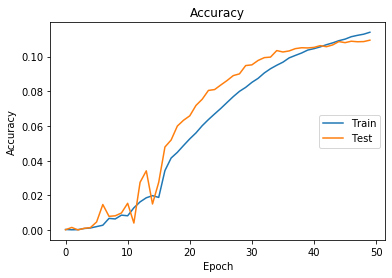

In [35]:
plot_history(
    merge_all_histories(TRAINING_SESSION.training_history), 
    ["accuracy", "val_accuracy"], 
    ["Train", "Test"], 
    "Accuracy", "Accuracy")

### Plot categorical accuracy

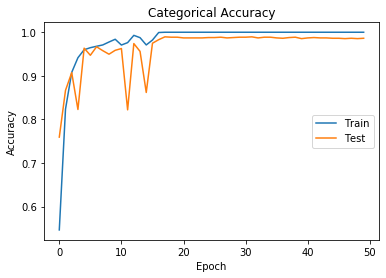

In [36]:
#plt.figure(dpi=200)
plot_history(
    merge_all_histories(TRAINING_SESSION.training_history), 
    ["categorical_accuracy", "val_categorical_accuracy"], 
    ["Train", "Test"], 
    "Accuracy", "Categorical Accuracy")

### Plot categorical crossentropy loss


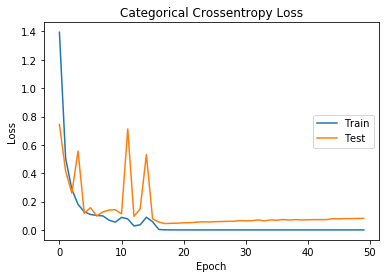

In [37]:
#plt.figure(dpi=200)
plot_history(
    merge_all_histories(TRAINING_SESSION.training_history), 
    ["loss", "val_loss"], 
    ["Train", "Test"], 
    "Loss", "Categorical Crossentropy Loss")

### Predict all images

In [0]:
preds, labels, images, paths = predict_all_test_images(MODEL, TEST_PATH_SORTED)

### Plot confusion matrix

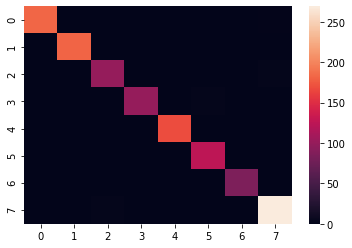

array([[182,   0,   0,   0,   0,   0,   0,   2],
       [  0, 181,   0,   0,   0,   0,   0,   0],
       [  0,   1, 100,   0,   0,   1,   0,   3],
       [  0,   0,   0, 100,   0,   3,   0,   0],
       [  0,   0,   0,   0, 169,   0,   0,   1],
       [  0,   1,   0,   1,   0, 126,   0,   0],
       [  0,   0,   0,   0,   0,   0,  86,   0],
       [  0,   1,   3,   0,   0,   0,   0, 269]])

In [39]:
from sklearn.metrics import confusion_matrix
import os
import seaborn as sn

confusion = confusion_matrix(labels, preds)

#plt.figure(dpi=200)
sn.heatmap(confusion)
plt.show()

confusion

### Find all falsely classified images

In [40]:
false_preds, false_labels, false_images, false_paths = find_falsely_classified_images(preds, labels, images, paths)

for i in range(0, len(false_preds)):
  print("label(%d) prediction(%d) %s %s" % (false_labels[i], false_preds[i], false_images[i], false_paths[i]))

label(5) prediction(3) 2937.png /home/data/Robo Cup/test_sorted/5/2937.png
label(5) prediction(1) 1344.png /home/data/Robo Cup/test_sorted/5/1344.png
label(7) prediction(2) 6238.png /home/data/Robo Cup/test_sorted/7/6238.png
label(7) prediction(2) 3365.png /home/data/Robo Cup/test_sorted/7/3365.png
label(7) prediction(2) 2765.png /home/data/Robo Cup/test_sorted/7/2765.png
label(7) prediction(1) 2283.png /home/data/Robo Cup/test_sorted/7/2283.png
label(4) prediction(7) 6034.png /home/data/Robo Cup/test_sorted/4/6034.png
label(2) prediction(7) 3389.png /home/data/Robo Cup/test_sorted/2/3389.png
label(2) prediction(7) 8881.png /home/data/Robo Cup/test_sorted/2/8881.png
label(2) prediction(7) 350.png /home/data/Robo Cup/test_sorted/2/350.png
label(2) prediction(1) 6321.png /home/data/Robo Cup/test_sorted/2/6321.png
label(2) prediction(5) 342.png /home/data/Robo Cup/test_sorted/2/342.png
label(0) prediction(7) 5005.png /home/data/Robo Cup/test_sorted/0/5005.png
label(0) prediction(7) 6274.p

### Plot falsely classified images


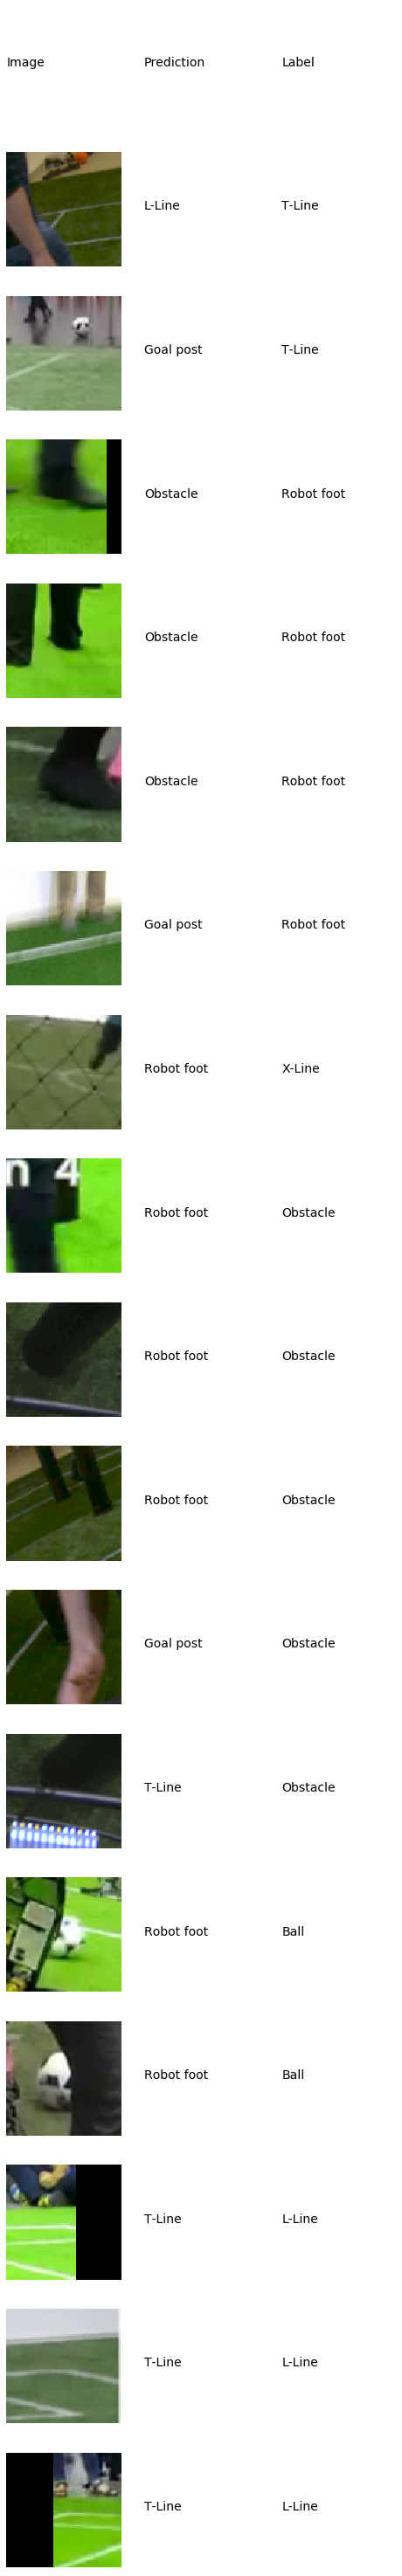

In [41]:
plot_falsely_classified_images(false_preds, false_labels, false_images, false_paths)

### Export falsely classified images

In [0]:
export_falsely_classified_images(false_preds, false_labels, false_images, false_paths, 
  os.path.join(REMOTE_OUTPUT_ANALYSIS_PATH, "false_predictions"))

### Multi class prediction

In [43]:
# get predictions before softmax regularization
def create_prediction_probabilities_model(model):
  # replace last softmax layer from ImageNet domain with new soft max layer for our RoboCup domain 
  x = tf.keras.layers.Dense(8, activation='sigmoid', name='predictions')(model.layers[-2].output)
  # create new model
  return tf.keras.models.Model(inputs=model.input, outputs=x)

probabilities_model = create_prediction_probabilities_model(MODEL)
probabilities_model


In [44]:
probabilities_model.predict
INPUT_SIZE = probabilities_model.input_shape[1:3]
img = tf.keras.preprocessing.image.load_img("/home/data/Robo Cup/test_sorted/0/5005.png", target_size=INPUT_SIZE)
img_as_array = tf.keras.preprocessing.image.img_to_array(img)
multi_prediction = probabilities_model.predict(np.array([img_as_array]))
single_prediction = MODEL.predict(np.array([img_as_array]))

for prob in single_prediction[0]:
  print(prob)
print()

for prob in multi_prediction[0]:
  print(prob)

0.20759663
1.3828237e-07
1.4536871e-05
4.0384524e-08
0.0018699209
2.2286848e-08
0.00022325227
0.7902954

0.5874627
0.5824634
0.43224677
0.7185606
0.62073916
0.43856224
0.38464764
0.43322027


### Test single images

probabilities: [[3.2935245e-17 1.0000000e+00 1.2780921e-16 7.8739690e-19 1.0096853e-17
  2.5899967e-22 1.9131919e-23 1.8133080e-17]]
argmax: 1


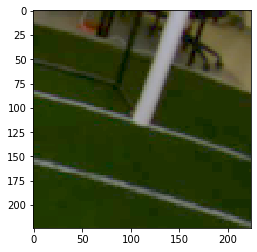

In [45]:
# test a particular image
test_image(MODEL, os.path.join(TEST_PATH_SORTED, "1/1761.png"))

### Visualize model

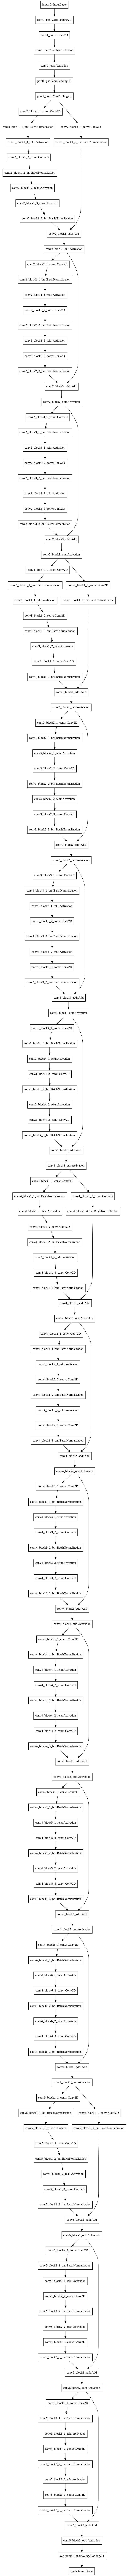

In [46]:
# visualize model
tf.keras.utils.plot_model(MODEL)

## Multiple models analysis

### Compare ResNet-152 and DenseNet-169

Loading session from: /gdrive/My Drive/colab/output/ResNet-Layers/ResNet-152/session.pickle
Loading session from: /gdrive/My Drive/colab/output/ResNet-Model/ResNet-152-DenseNet-169/session.pickle


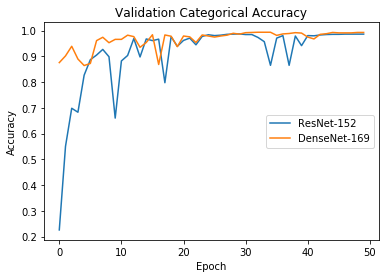

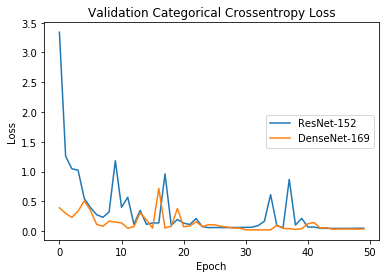

In [48]:
#plt.figure(dpi=400)
sessions = load_sessions([
  "/gdrive/My Drive/colab/output/ResNet-Layers/ResNet-152/session.pickle",
  "/gdrive/My Drive/colab/output/ResNet-Model/ResNet-152-DenseNet-169/session.pickle"])
histories = list(map(lambda session: merge_all_histories(session.training_history), sessions))
plot_histories(histories, "val_categorical_accuracy", ["ResNet-152", "DenseNet-169"], "Accuracy", "Validation Categorical Accuracy")
plot_histories(histories, "val_loss", ["ResNet-152", "DenseNet-169"], "Loss", "Validation Categorical Crossentropy Loss")

### Compare ResNet-50 -151 -151

Loading session from: /gdrive/My Drive/colab/output/Default/ResNet-50/session.pickle
Loading session from: /gdrive/My Drive/colab/output/ResNet-Layers/ResNet-101/session.pickle
Loading session from: /gdrive/My Drive/colab/output/ResNet-Layers/ResNet-152/session.pickle


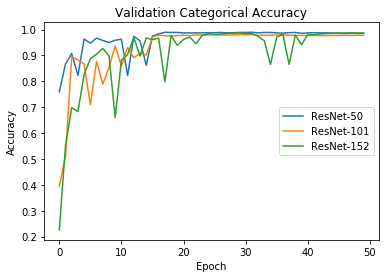

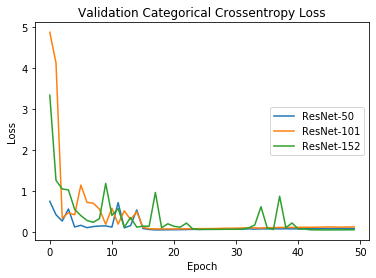

In [49]:
#plt.figure(dpi=400)
sessions = load_sessions([
  "/gdrive/My Drive/colab/output/Default/ResNet-50/session.pickle",
  "/gdrive/My Drive/colab/output/ResNet-Layers/ResNet-101/session.pickle",
  "/gdrive/My Drive/colab/output/ResNet-Layers/ResNet-152/session.pickle"])
histories = list(map(lambda session: merge_all_histories(session.training_history), sessions))
plot_histories(histories, "val_categorical_accuracy", ["ResNet-50", "ResNet-101", "ResNet-152"], "Accuracy", "Validation Categorical Accuracy")
plot_histories(histories, "val_loss", ["ResNet-50", "ResNet-101", "ResNet-152"], "Loss", "Validation Categorical Crossentropy Loss")

### Compare Optimizers Adam, Adadelta, SGD

Loading session from: /gdrive/My Drive/colab/output/Default/ResNet-50/session.pickle
Loading session from: /gdrive/My Drive/colab/output/ResNet-Optimizer/ResNet-Adadelta/session.pickle
Loading session from: /gdrive/My Drive/colab/output/ResNet-Optimizer/ResNet-SGD/session.pickle


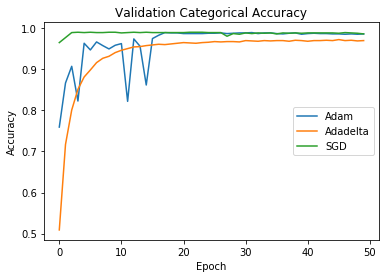

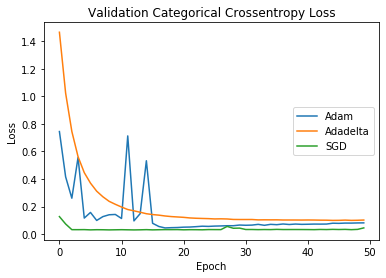

In [50]:
#plt.figure(dpi=400)
sessions = load_sessions([
  "/gdrive/My Drive/colab/output/Default/ResNet-50/session.pickle",
  "/gdrive/My Drive/colab/output/ResNet-Optimizer/ResNet-Adadelta/session.pickle",
  "/gdrive/My Drive/colab/output/ResNet-Optimizer/ResNet-SGD/session.pickle"])
histories = list(map(lambda session: merge_all_histories(session.training_history), sessions))
plot_histories(histories, "val_categorical_accuracy",  ["Adam", "Adadelta", "SGD"], "Accuracy", "Validation Categorical Accuracy")
plot_histories(histories, "val_loss",  ["Adam", "Adadelta", "SGD"], "Loss", "Validation Categorical Crossentropy Loss")

# Run TensorBoard (nothing is tracked yet with TensorBoard)

Tutorial on how to run TensorBoard in Cloab:
[https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/](https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/)

The following code successfully starts TensorBoard. However nothing is tracked yet.

In [0]:
!nvidia-smi

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"